# Feature calculation
- ### This file generates the features for the Machine Learning models.



### Read in file and drop entries with no value.

In [1]:
import numpy as np
import pandas as pd
import warnings
# filter warnings messages from the notebook
warnings.filterwarnings('ignore')

# read in data and drop the nan columns
features = pd.read_pickle('material_2.pkl')
features = features.dropna()

### Create features from DOS.
- Extract DOS from CompleteDOS structures downloaded from Materials Project.
    - Take total DOS at Fermi energy.
    - Take partial DOS for magnetic atoms (Cr, Mn, Fe, Co) at Fermi energy.

In [2]:
import pymatgen.electronic_structure.core as electronic_structure
import pymatgen.core.periodic_table as table
import pymatgen.core.composition as composition
import matplotlib.pyplot as plt

def sum_spin(DOS):
    spin_up = electronic_structure.Spin(1)
    spin_down = electronic_structure.Spin(-1)
    # cope with the case that only spin up exist
    if(len(DOS) == 1):
        return DOS[spin_up]
    else:
        return DOS[spin_up] + DOS[spin_down]

def DOS_at_Fermi(DOS):
    Ef = DOS.efermi
    DOS_Ef = DOS.get_interpolated_value(Ef)
    return sum_spin(DOS_Ef)

def element_in_formula(formula, test_element):
    comp = composition.Composition(formula)
    element_set = set(comp.elements)
    elment = table.Element(test_element)
    return elment in element_set

def element_dDOS_at_Fermi(complete_DOS, element, formula):
    if element_in_formula(formula, element):
        MP_element = table.Element(element)
        MP_orbital = electronic_structure.OrbitalType(2)
        element_orbital_DOS = complete_DOS.get_element_spd_dos(MP_element)[MP_orbital]
        return DOS_at_Fermi(element_orbital_DOS)
    else:
        return 0


features['Tol_DOS'] =  features['DOS'].apply(DOS_at_Fermi)

mag_element_list = ['Fe', 'Cr', 'Mn', 'Co']
for element in mag_element_list:
    dDOS = []
    for i in range(len(features['Tol_DOS'])):
        formula = features.Formula.iloc[i]
        DOS = features.DOS.iloc[i]
        dDOS.append(element_dDOS_at_Fermi(DOS, element, formula))
    features[element + '_dDOS'] = dDOS

### Plot DOS to check if there is singular values.

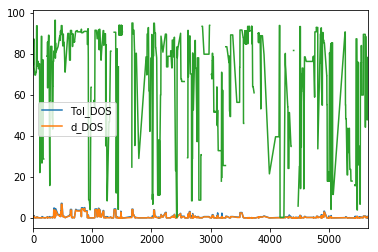

In [3]:
d_contribution = pd.Series(features.loc[:, "Fe_dDOS":"Co_dDOS"].sum(axis = 1)/features.loc[:, 'Tol_DOS'])
d_orbital_ratio = pd.DataFrame({ 'Tol_DOS': features.Tol_DOS,
                                'd_DOS': features.loc[:, "Fe_dDOS":"Co_dDOS"].sum(axis = 1),
                                'd_ratio': d_contribution*100})

d_orbital_ratio.loc[:,'Tol_DOS': 'd_DOS'].plot()
d_orbital_ratio.d_ratio.plot()

### Create features from materials' structure
- Coordination number (number of adjacent atoms).
- Distance between magnetic atoms.
- Magnetic moments of magnetic atoms.
- Lattice information (a, b, c, $\alpha$, $\beta$, $\gamma$).

In [4]:
# Find shortest lattice constant
def shortest_lc(structure):
    lattice = structure.as_dict()['lattice']
    return min(lattice['a'], lattice['b'], lattice['c'])

def index_2_magmom(struct, index):
    try:
        magmom = struct.site_properties['magmom'][index]
        return magmom
    except:
        return np.nan

# Calculate average magmom.
def cal_avg_magmom(struct, index_list):
    sum_magmom = 0
    for i in index_list:
        sum_magmom += index_2_magmom(struct, i)
    return  sum_magmom/len(index_list)


def is_magnetic(site, mag_atom = {'Cr', 'Mn', 'Fe', 'Co'}):
    try:
        return site.species_string in mag_atom
    except:
        return site[0].species_string in mag_atom

def find_mag_sites(sites):
    mag_list = []
    for site in sites:
        if(is_magnetic(site)):
            mag_list.append(site)
    return mag_list

def find_neighbor_num(neighbor_list):
    try:
        add_neighbor = [neighbor_list[0][2]]
    except:
        pass
        # print('neighbor_list length: '+str(len(neighbor_list)))
    add_dist = [neighbor_list[0][1]]
    for i in range(1, len(neighbor_list)):
        if(neighbor_list[i][1] < 1.2*(neighbor_list[i - 1][1])):
            add_neighbor.append(neighbor_list[i][2])
            add_dist.append(neighbor_list[i][1])
        else:
            break        
    return add_neighbor, add_dist


def find_coor_num(struct):
    site_list = find_mag_sites(struct.sites)
    smallest_lc = shortest_lc(struct)
    avg_dist = np.zeros(len(site_list))
    avg_coor_num = np.zeros(len(site_list))
    avg_magmom = np.zeros(len(site_list))
    
    for i, sites in enumerate(site_list):
        neighbor_list_all = struct.get_neighbors(sites, smallest_lc, include_index=True)
        neighbor_list = find_mag_sites(neighbor_list_all)
        neighbor_list.sort(key = lambda x: x[1])
        # Find neighbor list with smallest distance (or with 20%).
        index_list, dist_list = find_neighbor_num(neighbor_list)
        avg_dist[i] = np.array([dist_list]).mean()
        avg_coor_num[i] = len(index_list)
        avg_magmom[i] = cal_avg_magmom(struct, index_list)
    return avg_coor_num.mean(), avg_magmom.mean(), avg_dist.mean() 

def get_lattice_info(structure):
    lattice = structure.as_dict()['lattice']
    return lattice['a'], lattice['b'], lattice['c'], \
        lattice['alpha'], lattice['beta'], lattice['gamma']

def structure_information(structures):
    avg_coor_list = []
    avg_magmom_list = []
    avg_dist_list = []
    lattice_a = []
    lattice_b = []
    lattice_c = []
    lattice_alpha = []
    lattice_beta = []
    lattice_gamma = []
    for i, structure in enumerate(structures):
        try:
            avg_coor, avg_magmom, avg_dist = find_coor_num(structure)
            a, b, c, alpha, beta, gamma = get_lattice_info(structure)
        except:
            avg_coor = np.nan
            avg_magmom = np.nan
            avg_dist = np.nan
            a = np.nan
            b = np.nan
            c = np.nan
            alpha = np.nan
            beta = np.nan
            gamma = np.nan
        avg_coor_list.append(avg_coor)
        avg_magmom_list.append(avg_magmom)
        avg_dist_list.append(avg_dist)
        lattice_a.append(a)
        lattice_b.append(b)
        lattice_c.append(c)
        lattice_alpha.append(alpha)
        lattice_beta.append(beta)
        lattice_gamma.append(gamma)
    return [avg_coor_list, avg_magmom_list, avg_dist_list, \
            lattice_a, lattice_b, lattice_c, lattice_alpha,\
            lattice_beta, lattice_gamma]


features['Coordnate_Number'], features['Magnetic_moment'], features['Bound_Length'], \
    features['lattice_a'], features['lattice_b'], features['lattice_c'], \
    features['lattice_alpha'], features['lattice_beta'], features['lattice_gamma'] \
    = structure_information(features['structure'])


### Drop materials' structure to save space.

In [5]:
features = features.drop(columns = 'structure')
features = features.dropna(axis=0)

### Save to pickle file.

In [6]:
features.to_pickle('feature.pkl')

### Comparing the difference between shortest distance to average bond length.

(array([   4.,    0.,    0.,    4.,   48.,  960., 1874.,   78.,    7.,
          98.]),
 array([-1.        , -0.84214113, -0.68428225, -0.52642338, -0.3685645 ,
        -0.21070563, -0.05284676,  0.10501212,  0.26287099,  0.42072987,
         0.57858874]),
 <a list of 10 Patch objects>)

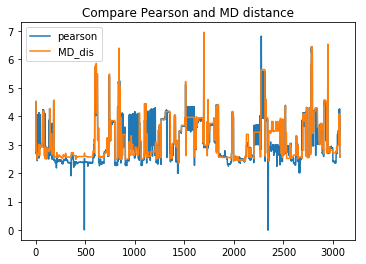

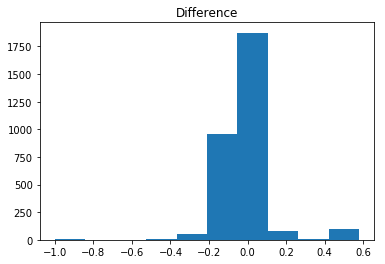

In [7]:
pearson_dis =  np.array(features.Near_Distance, dtype = float)
MD_dis = np.array(features.Bound_Length, dtype = float)
diff_percentage = (pearson_dis - MD_dis)/MD_dis

plt.figure(1)
plt.plot(pearson_dis)
plt.plot(MD_dis)
plt.title("Compare Pearson and MD distance")
plt.legend(["pearson", "MD_dis"])
plt.figure(2)
plt.title("Difference")
plt.hist(diff_percentage)